In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression

In [2]:
sig = 10.
rho = 28.
beta = 8./3

def Lorenz_model(v, sig=sig, rho=rho, beta=beta):
    x, y, z = v[...,0], v[...,1], v[...,2]
    
    dxdt = sig*(y-x)
    dydt = rho*x - y - x*z
    dzdt = x*y - beta*z
    
    return np.stack((dxdt, dydt, dzdt),axis=-1)

In [3]:
def RK4 (model, v, dt):
    k1 = model(v)
    k2 = model(v + dt*k1/2.)
    k3 = model(v + dt*k2/2.)
    k4 = model(v + dt*k3)
    return v + (1./6.)*dt*(k1 + 2*k2 + 2*k3 + k4)

In [4]:
v0 = np.array([1.509, -1.531, 25.46]) + 0.1*np.random.randn(3)
K = 50000
dt = 0.01


In [5]:
def simulate(forward, K, v0, N=0, burnin=500):
    """
    simulate an ensemble of forward models over K time steps.
    :forward: forward model
    :K: number of time steps to generate
    :N: enseømble size (if N=0, no ensemble)
    :v0: initial state (shape: (3,N)), if N=0. (shape: (3))
    :burnin: number of initial time step to discard (spinup period)
    """
    V = np.zeros((K+burnin,N,3)) if N>0 else np.zeros((K+burnin,3)) 
    V[0] = v0
    for i in range(1,K+burnin):
        V[i] =forward(V[i-1])
    return V[burnin:]

In [6]:
forward = lambda v: RK4(Lorenz_model, v,dt)

V = simulate(forward, K, v0)

In [7]:
V.shape

(50000, 3)

In [8]:
def phase_plot(V):
    """
    Plot the trajectory V in dense plot in the phase space
    """
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
    ax[1,0].hist2d(V[:,0],V[:,1], bins=(120,120), norm=mpl.colors.LogNorm(), cmap='summer');
    ax[0,0].hist2d(V[:,0],V[:,2], bins=(120,120), norm=mpl.colors.LogNorm(), cmap='summer');
    ax[0,1].hist2d(V[:,1],V[:,2], bins=(120,120), norm=mpl.colors.LogNorm(), cmap='summer');
    ax[1,1].axis('off');
    return fig, ax 

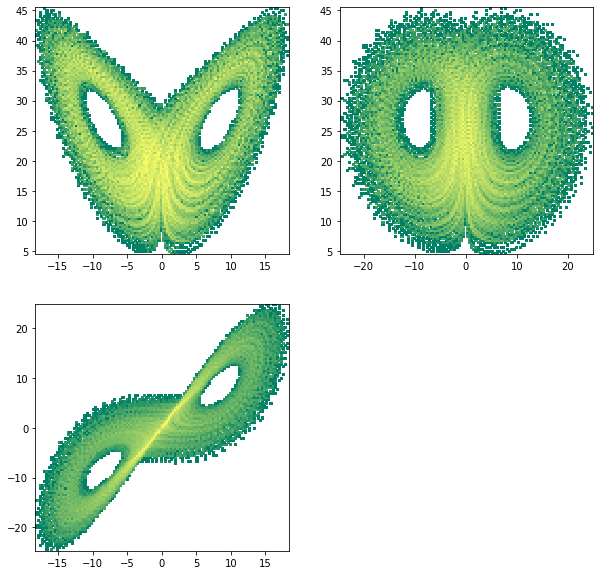

In [9]:
fig, ax = phase_plot(V)

In [28]:
# Training set/Val
Ktrain=10000
Kval = 5000
Ktest = 2000

Xtrain = V[0:Ktrain]
ytrain = V[1:Ktrain+1]

Xval = V[Ktrain:Ktrain+Kval]
yval = V[Ktrain+1:Ktrain+Kval+1]

Xval.shape

(5000, 3)

In [29]:
# Test set (ensemble)
v0test = np.array([1.509, -1.531, 25.46])[np.newaxis,:] + 0.1*np.random.randn(200,3)
Vtest = simulate(forward, Ktest, v0test, N=200)
v0test.shape


(200, 3)

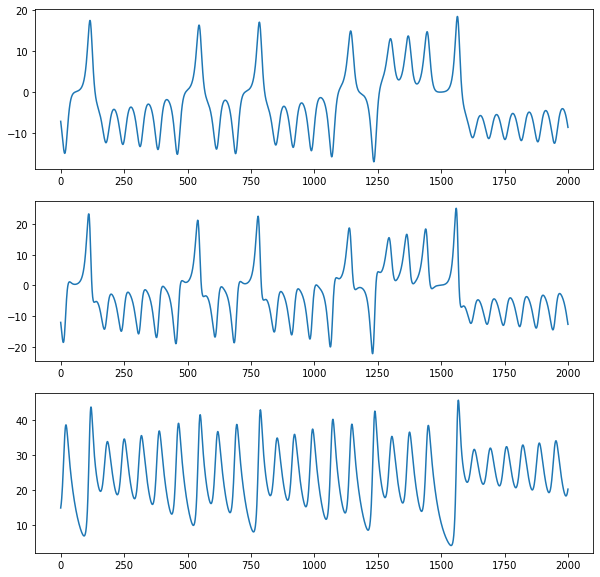

In [30]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(Vtest[:,0,0])
ax[1].plot(Vtest[:,0,1])
ax[2].plot(Vtest[:,0,2])


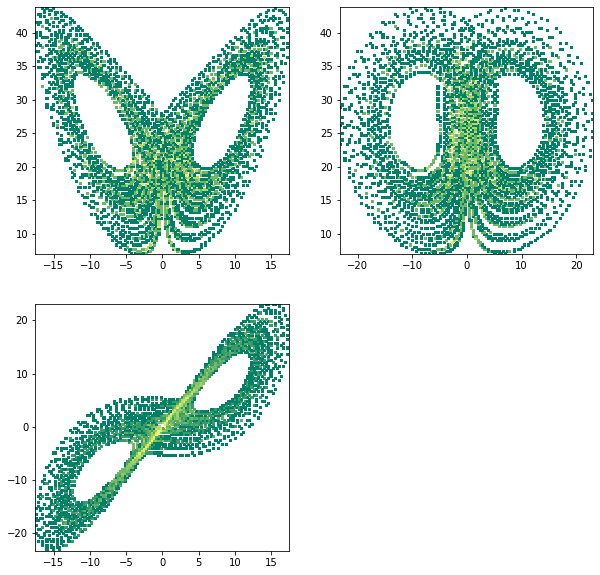

In [31]:
fig, ax = phase_plot(Xval)

In [32]:
reg = LinearRegression().fit(Xtrain, ytrain)


In [33]:
ylin = reg.predict(Xval)

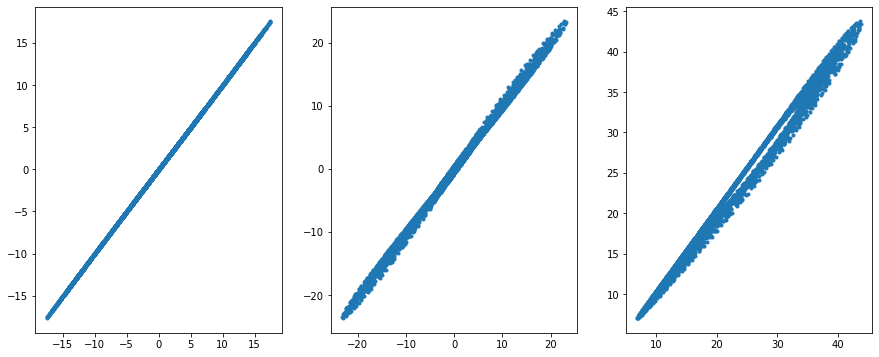

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
ax[0].plot(yval[:,0],ylin[:,0],'.')
ax[1].plot(yval[:,1],ylin[:,1],'.')
ax[2].plot(yval[:,2],ylin[:,2],'.')

In [35]:
Vtestlin = simulate(reg.predict, Ktest, Vtest[0], N=200,burnin=0)


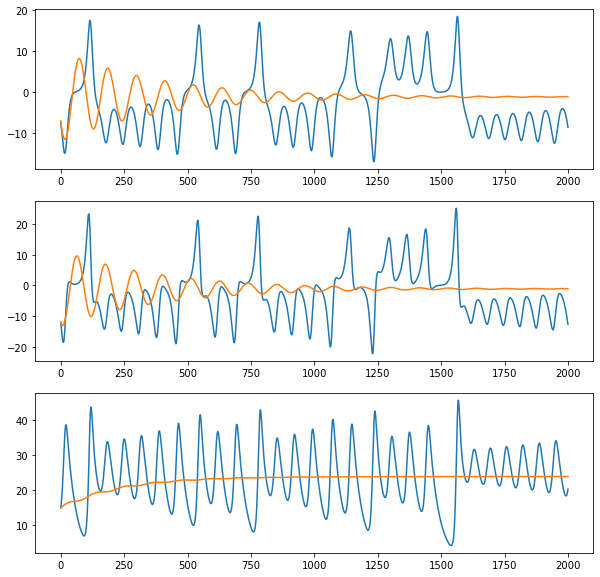

In [36]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(Vtest[:,0,0])
ax[1].plot(Vtest[:,0,1])
ax[2].plot(Vtest[:,0,2])
ax[0].plot(Vtestlin[:,0,0])
ax[1].plot(Vtestlin[:,0,1])
ax[2].plot(Vtestlin[:,0,2])

In [37]:
import tensorflow.keras as keras


/Users/julaja/opt/anaconda3/envs/course/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/julaja/opt/anaconda3/envs/course/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/julaja/opt/anaconda3/envs/course/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/julaja/opt/anaconda3/env

In [95]:
mean_ = np.mean(Xtrain,axis=0,keepdims=True)
std_= np.std(Xtrain,axis=0, keepdims=True)


norm = lambda x: (x-mean_)/std_
denorm = lambda x: x*std_ + mean_


In [111]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [122]:
nn_model = keras.Sequential(
    [
        layers.Dense(40, activation="relu", name="layer1", input_shape=(3,)),
        layers.Dense(20, activation="relu", name="layer2"),
        layers.Dense(3, name="output"),
    ])

In [123]:
nn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 40)                160       
_________________________________________________________________
layer2 (Dense)               (None, 20)                820       
_________________________________________________________________
output (Dense)               (None, 3)                 63        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________


In [124]:
nn_model.compile(optimizer='RMSprop', loss='mse')

In [125]:
nn_model.fit(norm(Xtrain),ytrain, validation_data=(norm(Xval),yval),epochs=50)

Train on 10000 samples, validate on 5000 samples
Epoch 1/50
10000/10000 [==============================] - 1s 83us/sample - loss: 91.9049 - val_loss: 8.5421
Epoch 2/50
10000/10000 [==============================] - 0s 31us/sample - loss: 2.5063 - val_loss: 0.2804
Epoch 3/50
10000/10000 [==============================] - 0s 38us/sample - loss: 0.1117 - val_loss: 0.0442
Epoch 4/50
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0345 - val_loss: 0.0512
Epoch 5/50
10000/10000 [==============================] - 1s 90us/sample - loss: 0.0235 - val_loss: 0.0277
Epoch 6/50
10000/10000 [==============================] - 1s 88us/sample - loss: 0.0199 - val_loss: 0.0189
Epoch 7/50
10000/10000 [==============================] - 1s 94us/sample - loss: 0.0175 - val_loss: 0.0213
Epoch 8/50
10000/10000 [==============================] - 1s 101us/sample - loss: 0.0162 - val_loss: 0.0205
Epoch 9/50
10000/10000 [==============================] - 1s 63us/sample - loss: 0.0151 - val

In [126]:
ynn = nn_model.predict(norm(Xval))

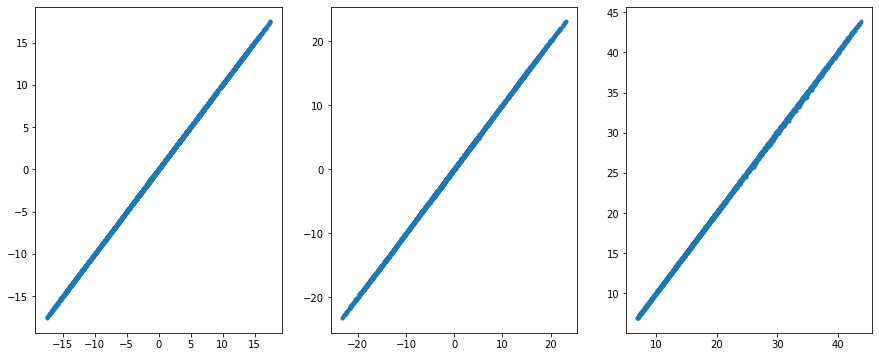

In [127]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
ax[0].plot(yval[:,0],ynn[:,0],'.')
ax[1].plot(yval[:,1],ynn[:,1],'.')
ax[2].plot(yval[:,2],ynn[:,2],'.')

In [128]:
forward_nn = lambda v: nn_model.predict(norm(v))

In [129]:
Vtestnn = simulate(forward_nn, Ktest, Vtest[0], N=200,burnin=0)


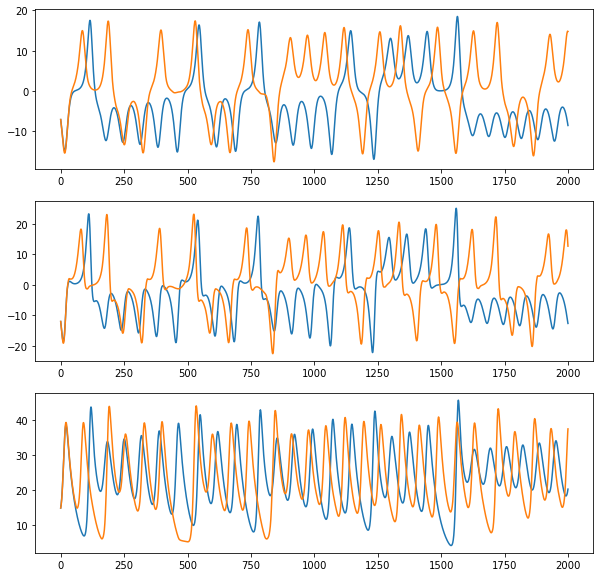

In [130]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10))
ax[0].plot(Vtest[:,0,0])
ax[1].plot(Vtest[:,0,1])
ax[2].plot(Vtest[:,0,2])
ax[0].plot(Vtestnn[:,0,0])
ax[1].plot(Vtestnn[:,0,1])
ax[2].plot(Vtestnn[:,0,2])

In [132]:
Vtestnn = simulate(forward_nn, K, Vtest[0,0], burnin=0)


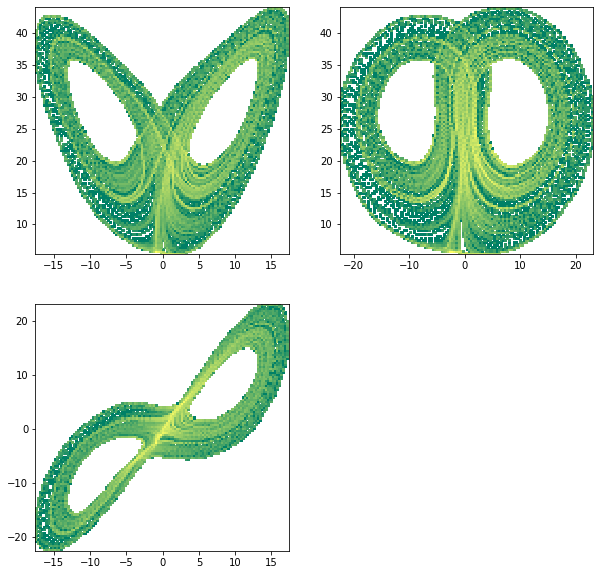

In [133]:
fig, ax = phase_plot(Vtestnn)